# SWASH 2D Willapa
As before, but longer period

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

f = "/home/cassandra/Willapa/willapa_bathy_liveocean.nc"
nc = xr.open_dataset(f)

depth = -1*nc.h.values.flatten()
lats = nc.lat_rho.values.flatten()
lons = nc.lon_rho.values.flatten()
points = np.array([lons, lats])

### Reduce resolution significantly

In [2]:
# First add 10 meters to all zero points on the bathy
depth[depth == -0.2] = 10

# Now get a UTM range for the model
import utm

# Convert a lat/lon bounding box to a UTM range
lat0, lon0 = 46.35, -124.05
x0, y0, _, __ = utm.from_latlon(lat0, lon0)
lat1, lon1 = 46.76, -123.77
x1, y1, _, __ = utm.from_latlon(lat1, lon1)

xrange = np.linspace(x0, x1, 100)
yrange = np.linspace(y0, y1, 200)

# Convert each lat/lon pair to utm
xs, ys = [], []
for lat, lon in zip(lats, lons):
    x, y, _, __ = utm.from_latlon(lat, lon)
    xs.append(x)
    ys.append(y)
xy = np.array([xs,ys]).T  # Convert to [N,2] shape

# Interpolate the unstructured bathy onto a grid
import scipy.interpolate
xx, yy = np.meshgrid(xrange, yrange)
zz = scipy.interpolate.griddata(xy, depth, (xx, yy))

# Get an x/y grid in problem coordinates
xp = xrange - xrange[0]
yp = yrange - yrange[0]

### 500 to 2000 seconds

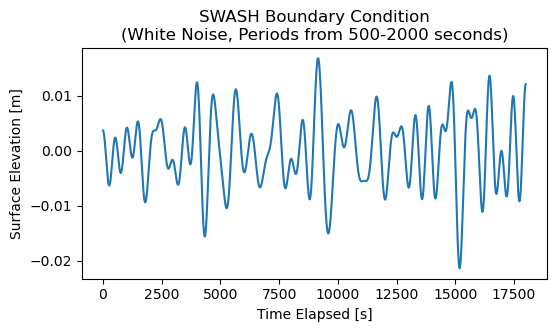

In [3]:
from scipy.fftpack import ifft, fftfreq, fftshift, fft

# Generate time stamp
dt = 1.0
t = np.arange(0, 12*3600, dt)

# Generate theoretical frequencies associated with fourier transforming the timestamps 
freq = fftfreq(len(t), d=dt)

# Generate theoretical fourier components.
# Magnitude = 1, but phase is random.
Fa = np.exp(np.random.rand(len(t))*2*np.pi)

# Set all frequencies outside our interest frequencies to 0
freq_of_interest = np.logical_and(np.abs(freq) > 1/2000, np.abs(freq) < 1/500)
Fa[~freq_of_interest] = 0

# Inverse fft
a = np.real(ifft(Fa))


# Set significant wave height to like, 1 cm
a = a * 0.01 / np.std(a)  # Factor of 4 in numerator/denominator from Hsig cancels out

# Get a chunk in the middle of the time series
t = t[3600:6*3600]
a = a[3600:6*3600]
t = t-t[0]

# Sanity plot first 500 seconds
plt.figure(figsize=(6,3))
plt.plot(t, a)
plt.title("SWASH Boundary Condition\n(White Noise, Periods from 500-2000 seconds)")
plt.xlabel("Time Elapsed [s]")
plt.ylabel("Surface Elevation [m]")
plt.show()

In [4]:
import os

def ensure_dir(path):
    dir = os.path.dirname(path)
    if not os.path.exists(dir):
        os.makedirs(dir)

ensure_dir('/home/cassandra/Willapa/SWASH2D-test-2/')
os.chdir('/home/cassandra/Willapa/SWASH2D-test-2/')

Next, I'll do the coordinates and bathy file. They need to be formatted carefully but this is easily done with pandas. 

In [5]:
import pandas as pd

# How many grid cells in x,y
mxc = len(xp) - 1
myc = len(yp) - 1

# I prefer things in problem coordinates
xx, yy = np.meshgrid(xp, yp)

# Coordinates / Grid file
grid_data = {}
for i in range(mxc+1):
    grid_data.update({i:np.append(xx[:,i], yy[:,i])})
grid_2d_df = pd.DataFrame.from_dict(grid_data)
grid_2d_df.to_csv('coords.txt', sep=' ', header=False, index=False)

# Bathy
bot_2d_df = pd.DataFrame.from_dict({str(i):np.around(zz[:,i],2) for i in range(mxc+1)})
bot_2d_df.to_csv('bathy.txt', sep=' ', header=False, index=False)    

In [6]:
# Method for converting time (in seconds) to a format SWASH input likes
def format_time(t):
    hours = int(t/3600)
    minutes = int(t/60 % 60)
    seconds = int(t % 60)
    ms = int(1000*(t % 1))
    return str(hours).zfill(2) + str(minutes).zfill(2) + str(seconds).zfill(2) + '.' + str(ms).zfill(3)

# Time series file    
file_content = ""
for j in range(len(t)):
    file_content += format_time(t[j]) + ' ' + "{:.7f}".format(np.around(a[j], 8)) + '\n'
with open('bc.txt', 'w') as file:
    file.write(file_content)

In [7]:
bc_str = "BOUN SEGMENT XY 0 32800 0 42100 BTYPE WEAKrefl CON SERIes 'bc.txt' 7"

In [8]:
model_time = 5*3600
hours, minutes, seconds = int(model_time/3600), int(model_time/60 - 60*int(model_time/3600)), model_time%60
timestr = "{hours:02d}{minutes:02d}{seconds:02d}.000".format(hours=hours, minutes=minutes, seconds=seconds)

In [9]:
template = """
$
$*************** INPUT *********************
$
PROJ 'default' '01'
MODE NONSTationary TWODimensional
$
CGRID CURV {mxc} {myc}
READgrid COORdinates 1 'coords.txt' 1 0 0 FREE
VERT 1
INPgrid BOTtom CURV EXCeption 10.0
READinp BOTtom -1 'bathy.txt' 1 0 FREE
SET depmin = 0.010
SET level = 0
{bc_str}
$
$*************** PHYSICS *********************
$
FRIC MANN 0.019
SET BACKVISC 1.e-4
BREAK 0.6 0.3
VISC VERT KEPS
$
$*************** NUMERICS *********************
$
NONHYDROSTATIC BOX 1. PRECONDITIONER ILU
DISCRET CORRDEP MUSCL 
DISCRET UPW UMOM MOM VERT FIR
DISCRET UPW UMOM MOM HOR MUSCL
DISCRET UPW WMOM VERT FIR
DISCRET UPW WMOM HOR MUSCL
TIMEI 0.4 0.8
$
$
$************ OUTPUT REQUESTS *************************  
$
BLOCK 'COMPGRID' NOHEAD 'output.mat' XP YP BOTL WATL OUTPUT 000000.000 5.0 SEC
TEST 1 0
COMPUTE 000000.000 0.01 SEC {timestr}
STOP
"""

ini_string = template.format(mxc=mxc, myc=myc, timestr=timestr, bc_str=bc_str)
input_file = open('INPUT', "w")
input_file.write(ini_string)
input_file.close()

In [16]:
xp.shape

(100,)

In [17]:
# Load the matlab file
maf = 'output.mat'
m = scipy.io.loadmat(maf)

# Get x and y coordinates. 
x = xp #np.unique(m['Xp'])
y = yp #np.unique(m['Yp'])

# Get bed elevation
z_bottom = m['Botlev']

# Parse each key in the matlab file to grab the timestamp
t = []
for key_str in list(m.keys())[6:]:
    key_str_split = key_str.split('_')
    milliseconds = np.timedelta64( int(key_str_split[-1]),         'ms')
    seconds      = np.timedelta64( int(key_str_split[-2][-2:]),    's')
    minutes      = np.timedelta64( int(key_str_split[-2][-4:-2]),  'm')
    hours        = np.timedelta64( int(key_str_split[-2][-6:-4]),  'h')
    td = np.timedelta64(hours + minutes + seconds + milliseconds)
    t.append(td)

# Evaluate the unique values and use that as the available timesteps
t = np.unique(t)
t = np.array(t).astype('timedelta64[ms]')

# Only load the surface elevation timeseries (which is called 'Watlev')
# Read each key in the matlab file, classify and put in correct list
eta = []
for key_str in list(m.keys())[3:]:
    if 'Watlev' in key_str:
        eta.append(m[key_str])

# Write to a netcdf file
data_dict = {  'eta': (['t', 'y', 'x'], np.array(eta)),
             'z_bed': ([     'y', 'x'], z_bottom) }
coords_dict = {'x':x, 'y':y, 't':t}
out_ds = xr.Dataset(data_dict, coords=coords_dict)
out_ds.to_netcdf('output.nc')

/home/cassandra/anaconda3/lib/python3.13/site-packages/numpy/_core/_methods.py:173: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/home/cassandra/anaconda3/lib/python3.13/site-packages/numpy/_core/_methods.py:194: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


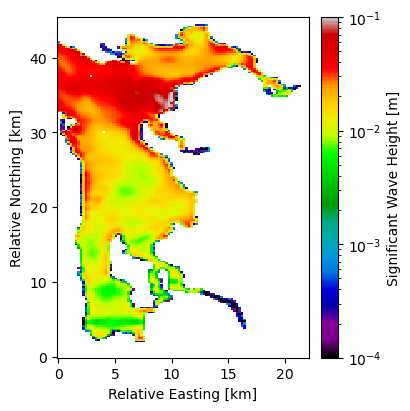

In [18]:
Hs = 4*np.std(out_ds.eta.values, axis=0)
Hs[out_ds.z_bed.values == -10] = np.nan
Hs[Hs <= 1e-8] = 1e-8

plt.figure(figsize=(4,4), constrained_layout=True)
cf = plt.pcolormesh(x/1000, y/1000, Hs, cmap='nipy_spectral', norm='log', shading='nearest', vmin=1e-4, vmax=1e-1)
cb = plt.colorbar(cf)
cb.ax.set_ylabel("Significant Wave Height [m]")
plt.xlabel("Relative Easting [km]")
plt.ylabel("Relative Northing [km]")
plt.show()

### Advanced SWASH Output - Resonant Modes
To get the resonant modes, I want to look at the spectrum at a few points in the bay, to see if any frequencies are elevated above baseline. I'll compare each to the spectrum of the boundary condition. First I'll load and plot the points around the bay, generated with https://geojson.io --

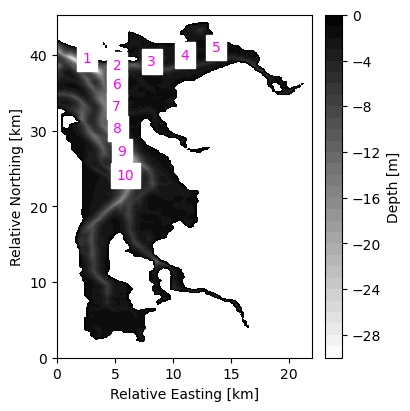

In [19]:
# Load the geojson file
import json
points_file = "../output_points.geojson"
js = json.load(open(points_file))

# Get latlon coordinates and convert to UTM
points_x, points_y = [], []
for point in js['features']:
    point_lon, point_lat = point['geometry']['coordinates']
    point_x, point_y, _, __ = utm.from_latlon(point_lat, point_lon)
    points_x.append(point_x)
    points_y.append(point_y)
points_x, points_y = np.array(points_x), np.array(points_y)

# Convert to problem coordinates
ppx, ppy = points_x - xrange[0], points_y - yrange[0]

# String number for each point to act as a label
num = [str(n) for n in range(1, len(points_x)+1)]

# Plot to show approx location of each point
plt.figure(figsize=(4,4), constrained_layout=True)
cf = plt.contourf(xp/1000, yp/1000, zz, levels=np.linspace(-30, 0, 31), cmap='binary')
cb = plt.colorbar(cf)
cb.ax.set_ylabel("Depth [m]")
for ppxx, ppyy, n in zip(ppx/1000, ppy/1000, num):
    plt.text(ppxx, ppyy, n, color='magenta', ma='center', backgroundcolor='white')
plt.xlabel("Relative Easting [km]")
plt.ylabel("Relative Northing [km]")
plt.show()

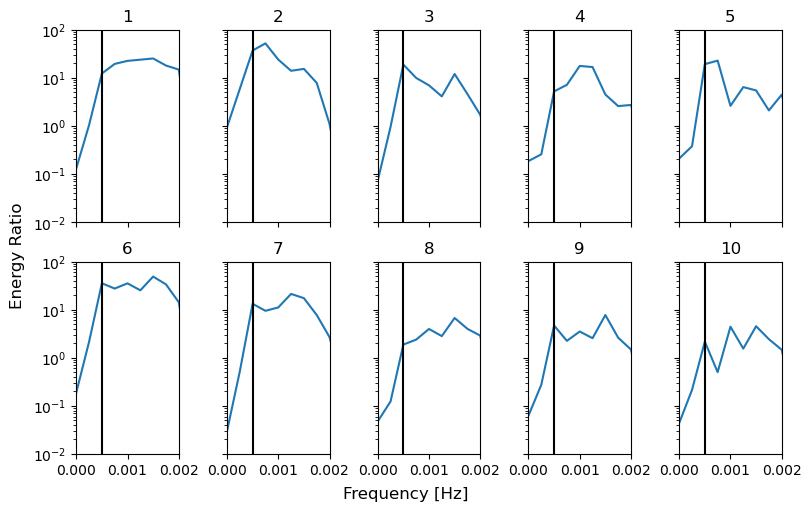

In [28]:
# Define some helper functions 
def cos_taper(a):
    x = np.linspace(-np.pi/2, np.pi/2, len(a))
    y = np.cos(x)
    tapered = y*a
    t_power = np.std(tapered)**2
    d_power = np.std(a)**2
    if d_power == 0: return a
    return tapered * d_power/t_power

def psd(a, dt=5.0, seg_time=4000):
    # segmenting
    seg_len = int(seg_time / dt)
    seg_indices = range(0, len(a) - int(seg_len), int(seg_len/2))
    seg_a = np.array([cos_taper(a[i:i+seg_len]) for i in seg_indices])
    # Evaluate frequency info
    freq = fftshift(fftfreq(seg_len, d=dt))
    df = freq[1] - freq[0]
    # FFT and go from amplitude to amp^2/Hz
    Fa = fftshift(fft(seg_a, axis=1), axes=1)
    Saa = np.real(np.nanmean((Fa * np.conj(Fa))/df, axis=0))
    # Drop negative frequencies
    Saa = 2*Saa[freq >= 0]
    freq = freq[freq >= 0]
    # Normalize energy
    ES = np.trapezoid(Saa, x=freq)
    Ea = np.std(a)**2
    Saa = Saa * Ea/ES
    return freq, Saa

# Get boundary spectrum
freq, bound_spec = psd(a)

# But assume its flat, for purposes of argument...
bound_spec = np.ones(len(freq))*np.nanmean(bound_spec[freq<0.02])

# Plot spectra for each point
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(8,5),
                        sharex=True, sharey=True, constrained_layout=True)
axs = axs.flatten()
for i, ppxx, ppyy, n in zip(range(len(num)), ppx, ppy, num):
    xi, yi = np.argmin(np.abs(x - ppxx)), np.argmin(np.abs(y-ppyy))
    point_eta = out_ds.eta[:,yi,xi].values
    freq, spec = psd(point_eta)
    axs[i].set_title(n)
    axs[i].plot(freq, spec/bound_spec)
    #axs[i].plot(freq, bound_spec, color='black')
    axs[i].axvline(0.0005, color='black')
#plt.loglog()
plt.xlim(0, 1/500)
plt.yscale('log')
plt.ylim(1e-2, 1e2)
fig.supxlabel("Frequency [Hz]")
fig.supylabel("Energy Ratio")
plt.show()

### 2000 Second Waves

/tmp/ipykernel_2530680/1171625985.py:12: RuntimeWarning: All-NaN slice encountered
  a_pass = a_pass + np.nanmedian(a)
/tmp/ipykernel_2530680/1171625985.py:12: RuntimeWarning: invalid value encountered in add
  a_pass = a_pass + np.nanmedian(a)


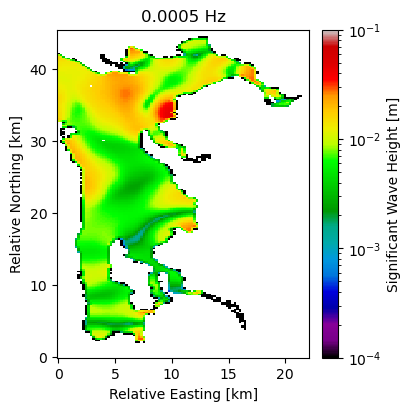

In [31]:
# Define frequency of interest
df = freq[1] - freq[0]
f = 0.0005

# Function to bandpass a time series
def freq_pass(a, f0, f1, dt=5.0):
    freq = fftfreq(len(a), d=dt)
    freq_ok = np.logical_and(np.abs(freq) >= f0, np.abs(freq) <= f1)
    F_a = fft(a)
    F_a[~freq_ok] = 0 
    a_pass = np.real(ifft(F_a))
    a_pass = a_pass + np.nanmedian(a)
    return a_pass

# Band pass at each point around frequency of interest
eta_passed = []
for xi in range(len(x)):
    eta_passed.append([])
    for yi in range(len(y)):
        point_eta = out_ds.eta[:,yi,xi].values
        eta_passed[-1].append(freq_pass(point_eta, f - df/2, f + df/2))

# Compute significant wave height
Hsf = 4*np.std(eta_passed, axis=2)
Hsf[out_ds.z_bed.values.T == -10] = np.nan

# Plot
plt.figure(figsize=(4,4), constrained_layout=True)
cf = plt.pcolormesh(x/1000, y/1000, Hsf.T, cmap='nipy_spectral', norm='log', shading='nearest', vmin=1e-4, vmax=1e-1)
cb = plt.colorbar(cf)
cb.ax.set_ylabel("Significant Wave Height [m]")
plt.xlabel("Relative Easting [km]")
plt.ylabel("Relative Northing [km]")
plt.title(str(f)+ " Hz")
plt.show()

### EOFs - Empirical Orthogonal Functions
It may be the pure significant wave height cannot resolve mode shapes, owing to progressive waves diluting the signal. For a quick analysis, EOFs may succeed where bandpassed significant wave height failed. 

In [32]:
import scipy

# To prepare to compute eigenvalues, need to flatten spatial dimensions and drop all NANs
eta_passed = np.array(eta_passed)
eta_flattened = eta_passed.reshape((len(x)*len(y), len(t)))
eta_passed[eta_passed >= 10] = np.nan # Drop dry values
nan_ok = np.sum(np.isnan(eta_flattened), axis=1) == 0

# Also reduce the accuracy, for speed
eta_flattened = eta_flattened.astype(np.float32)

In [33]:
# Singular value decomposition
U, s, Vh = scipy.linalg.svd(eta_flattened[nan_ok], full_matrices=False, check_finite=False)

In [34]:
# Reshape U from shape [de-nan'd len(x)*len(y), t] to [x,y,t]
# note the t dimension refers not to time but to EOF number
U_flattened = np.ones(eta_flattened.shape)*np.nan
U_flattened[nan_ok] = U
U_shaped = U_flattened.reshape((len(x), len(y), len(t)))

In [35]:
# Compute power from the SVDs
s_total = np.nansum(s[1:]**2) # Skip the first one, its just the average
s_relative = s**2 / s_total

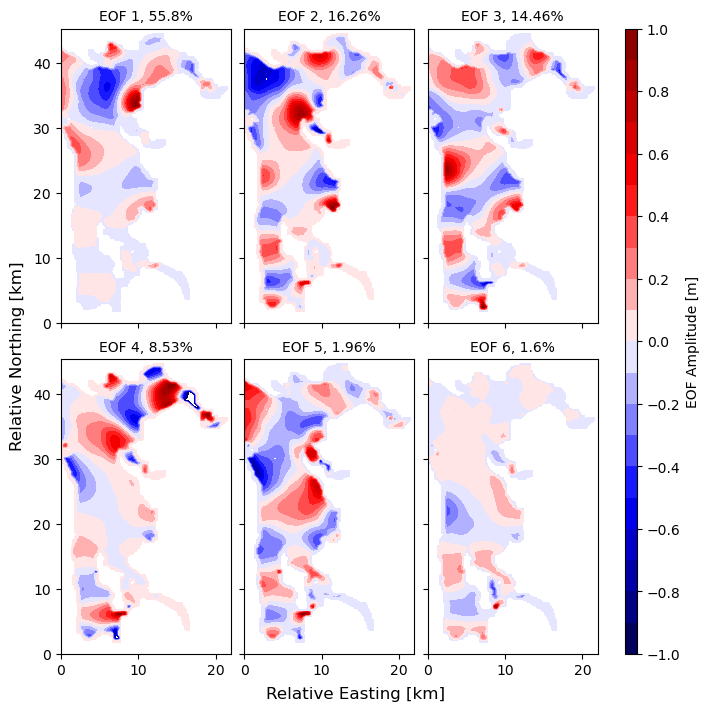

In [36]:
# Plot the first few EOFs
fig, axs = plt.subplots(ncols=3, nrows=2, sharex=True, sharey=True, constrained_layout=True, figsize=(7,7))
for i, ax in enumerate(axs.flatten()):
    EOF = U_shaped[:,:,i+1].T # Skip the first one (its just the average)
    EOF = EOF / np.nanmax(EOF)
    cf = ax.contourf(x/1000, y/1000, EOF, cmap='seismic', levels=np.linspace(-1, 1, 21))
    ax.set_title("EOF " + str(i+1) + ", " + str(np.around(100*s_relative[i+1], 2)) + "%", fontsize=10)
cb = plt.colorbar(cf, ax=axs, aspect=50, ticks=np.linspace(-1, 1, 11))
cb.ax.set_ylabel("EOF Amplitude [m]")
fig.supxlabel("Relative Easting [km]")
fig.supylabel("Relative Northing [km]")
plt.show()